<a href="https://colab.research.google.com/github/yara-esmaiel/Bitcoin-price-prediction/blob/main/Bitcoin_Price_Prediction_(GRU%2C_Layers%3D2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAYERS =2 , GRU
MODEL GRU
PENALITY =9
WINDOW SIZE = 15, 30 , 60
TIME= 1-1-2015 TO 24-6-2022   
ACTIVATION = RELU
recurrent_activation="sigmoid" (DEFAULT)
LOSS FUNCTION = CUSTOM


*   GRU
*   2-LAYER
*   ACTIVATION = RELU
*   recurrent_activation="sigmoid" (DEFAULT)
*   LOSS FUNCTION = CUSTOM

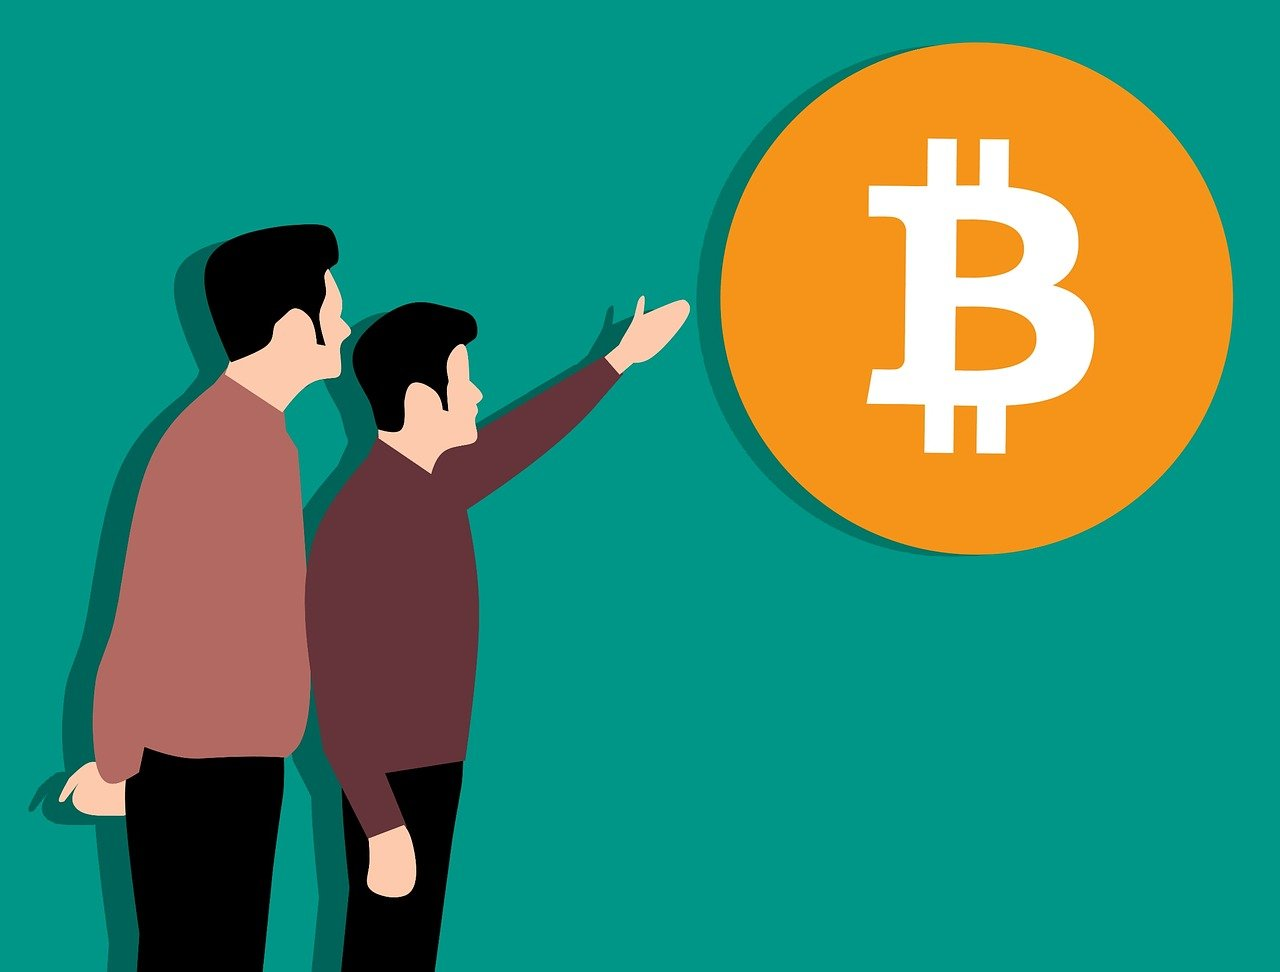

# Pre-Processing

In [1]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:

from numpy.random import seed
seed(1)
from tensorflow import keras
SEED = 1
keras.utils.set_random_seed(SEED)

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

In [4]:
# Load our dataset 
# Note it should be in same dir


maindf=pd.read_csv('/content/drive/MyDrive/BTC/BTC-USD from2014 to 24-6-2022.csv')

In [5]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-09-17
Ending Date 2022-06-24


In [6]:
maindf.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
maindf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2838 non-null   object 
 1   Open       2838 non-null   float64
 2   High       2838 non-null   float64
 3   Low        2838 non-null   float64
 4   Close      2838 non-null   float64
 5   Adj Close  2838 non-null   float64
 6   Volume     2838 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 155.3+ KB


In [8]:
maindf.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2.838000e+03
mean,12399.341018,12722.525499,12036.373224,12405.003057,12405.003057,1.539525e+10
std,16612.757792,17042.075739,16114.435061,16608.324661,16608.324661,1.995297e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,629.677506,639.339523,620.328247,630.604264,630.604264,8.595492e+07
50%,6532.800049,6635.975098,6447.389892,6532.510010,6532.510010,5.680985e+09
75%,11430.774658,11763.756836,11184.256103,11468.886963,11468.886963,2.628780e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [9]:
#Checking for Null Values
print('Null Values:',maindf.isnull().values.sum())


Null Values: 0


In [10]:
print('NA values:',maindf.isnull().values.any())


NA values: False


In [11]:
maindf.shape


(2838, 7)

In [12]:
# Lets First Take all the Close Price 
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2838, 2)


In [13]:
#Now we will Take data of just 1 Year

closedf = closedf[(closedf['Date'] > '2015-01-1') & (closedf['Date'] < '2022-06-15')]
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  2713


In [14]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
realdf=closedf
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)
print(closedf)

(2713, 1)
[[0.00143485]
 [0.00129928]
 [0.00133098]
 ...
 [0.39449545]
 [0.33105368]
 [0.32688985]]


In [15]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)
#print("train_data: ", train_data)
#print("test_data: ", test_data)


train_data:  (1627, 1)
test_data:  (1086, 1)


In [16]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# **window=15**

In [17]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1611, 15)
y_train:  (1611,)
X_test:  (1070, 15)
y_test (1070,)


In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1611, 15, 1)
X_test:  (1070, 15, 1)


In [19]:
y_test 

array([0.17775095, 0.16591142, 0.17269778, ..., 0.41821102, 0.39449545,
       0.33105368])

## **LOSS FUN**

In [20]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [21]:
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, LSTM, Dropout, GRU
modelGRU = Sequential()

modelGRU.add(GRU(128,input_shape=(X_train.shape[1], 1),activation="relu",return_sequences=True))
modelGRU.add(GRU(units = 64, input_shape = (X_train.shape[1], 1),activation="relu"))
modelGRU.add(Dense(1))
modelGRU.summary()

opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path15 = 'my_best_model15.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelGRU.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint15 = ModelCheckpoint(filepath=checkpoint_path15, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint15, earlystopping]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 128)           50304     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 87,617
Trainable params: 87,617
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = modelGRU.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
49/51 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0018
Epoch 1: val_mean_squared_error improved from inf to 0.11942, saving model to my_best_model15.hdf5
51/51 [==============================] - 5s 40ms/step - loss: 0.0026 - mean_squared_error: 0.0017 - val_loss: 0.2388 - val_mean_squared_error: 0.1194
Epoch 2/300
50/51 [============================>.] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0030
Epoch 2: val_mean_squared_error did not improve from 0.11942
51/51 [==============================] - 2s 30ms/step - loss: 0.0043 - mean_squared_error: 0.0030 - val_loss: 0.2898 - val_mean_squared_error: 0.1449
Epoch 3/300
50/51 [============================>.] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0033
Epoch 3: val_mean_squared_error did not improve from 0.11942
51/51 [==============================] - 2s 30ms/step - loss: 0.0052 - mean_squared_error: 0.0033 - val_loss: 0.2396 - val_mean_squared_error: 0.1199
Epoch 4/300
49

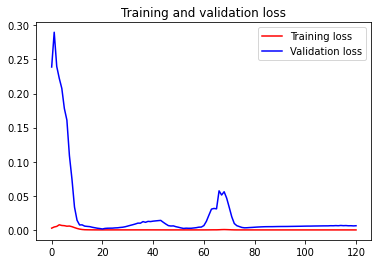

<Figure size 432x288 with 0 Axes>

In [23]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [24]:
from keras.models import load_model
model_from_saved_checkpoint15 = load_model('/content/my_best_model15.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [25]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint15.predict(X_train)
test_predict=model_from_saved_checkpoint15.predict(X_test)
train_predict.shape, test_predict.shape

((1611, 1), (1070, 1))

In [26]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [27]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])

test_predict 
 [[29500.477]
 [29336.006]
 [29268.5  ]
 [29728.781]
 [30032.574]
 [29891.021]
 [29701.848]
 [29226.426]
 [28635.812]]
original_ytest 
 [[29832.914063]
 [29906.662109]
 [31370.671875]
 [31155.478516]
 [30214.355469]
 [30111.998047]
 [29083.804688]
 [28360.810547]
 [26762.648438]]


## `RESULT W=15`

In [28]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  478.0485884675236
Train data MSE:  228530.45293579172
Train data MAE:  368.1756671904509
-------------------------------------------------------------------------------------
Test data RMSE:  1883.0329125134106
Test data MSE:  3545812.9496087376
Test data MAE:  1211.8158066514602


In [29]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9878093413055608
Test data explained variance regression score: 0.9914672675913991


In [30]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9834389190348397
Test data R2 score: 0.9897348097029214


In [31]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.20968211025259198
Test data MGD:  0.0030449230639377134
----------------------------------------------------------------------
Train data MPD:  136.33708486314052
Test data MPD:  88.2188016532621


## Custom Score 

In [32]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [33]:
Y_score(original_ytrain, train_predict)

Y error nigative : [-0.64528184]
Y error positive : [0.04391894]
Y total_error : [-0.6013629]


In [34]:
Y_score(original_ytest, test_predict)

Y error nigative : [-0.03559174]
Y error positive : [0.04272316]
Y total_error : [0.00713142]


In [35]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [36]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [37]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [38]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [39]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [40]:
time_step=15
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint15.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint15.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.4395539  0.4494726  0.43814878 0.44005597 0.44115034 0.46287519
 0.45968187 0.44571629 0.44419738 0.42893973 0.41821102 0.39449545
 0.33105368 0.32688985 0.35407647]
1 day output [[0.34835845]]
2 day input [0.4494726  0.43814878 0.44005597 0.44115034 0.46287519 0.45968187
 0.44571629 0.44419738 0.42893973 0.41821102 0.39449545 0.33105368
 0.32688985 0.35407647 0.34835845]
2 day output [[0.34537888]]
3 day input [0.43814878 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629
 0.44419738 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985
 0.35407647 0.34835845 0.34537888]
3 day output [[0.34291294]]
4 day input [0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.35407647
 0.34835845 0.34537888 0.34291294]
4 day output [[0.34059027]]
Output of predicted next days:  5


## Plotting last 15 days of dataset and next predicted 7 days

In [41]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20]


In [42]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[24038.865238665185, 23653.53498641464, 23452.745118749852, 23286.568999801806, 23130.04697369283]


In [43]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


# **window=30**

In [44]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1596, 30)
y_train:  (1596,)
X_test:  (1055, 30)
y_test (1055,)


In [45]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1596, 30, 1)
X_test:  (1055, 30, 1)


In [46]:
y_test 

array([0.14444165, 0.14382526, 0.13799897, ..., 0.41821102, 0.39449545,
       0.33105368])

## LOSS FUN

In [47]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [48]:
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, LSTM, Dropout, GRU
modelGRU = Sequential()

modelGRU.add(GRU(128,input_shape=(X_train.shape[1], 1),activation="relu",return_sequences=True))
modelGRU.add(GRU(units = 64, input_shape = (X_train.shape[1], 1),activation="relu"))
modelGRU.add(Dense(1))
modelGRU.summary()


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path30 = 'my_best_model30.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelGRU.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint30 = ModelCheckpoint(filepath=checkpoint_path30, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint30, earlystopping]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 30, 128)           50304     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 87,617
Trainable params: 87,617
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = modelGRU.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
49/50 [============================>.] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0018
Epoch 1: val_mean_squared_error improved from inf to 0.12728, saving model to my_best_model30.hdf5
50/50 [==============================] - 6s 62ms/step - loss: 0.0026 - mean_squared_error: 0.0017 - val_loss: 0.2546 - val_mean_squared_error: 0.1273
Epoch 2/300
50/50 [==============================] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0029
Epoch 2: val_mean_squared_error improved from 0.12728 to 0.10446, saving model to my_best_model30.hdf5
50/50 [==============================] - 3s 55ms/step - loss: 0.0046 - mean_squared_error: 0.0029 - val_loss: 0.2088 - val_mean_squared_error: 0.1045
Epoch 3/300
49/50 [============================>.] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0044
Epoch 3: val_mean_squared_error improved from 0.10446 to 0.10369, saving model to my_best_model30.hdf5
50/50 [==============================] - 3s 54ms/step - loss: 0.0065 - mean_squa

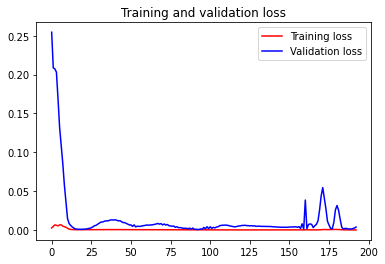

<Figure size 432x288 with 0 Axes>

In [50]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [51]:
from keras.models import load_model
model_from_saved_checkpoint30 = load_model('/content/my_best_model30.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [52]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint30.predict(X_train)
test_predict=model_from_saved_checkpoint30.predict(X_test)
train_predict.shape, test_predict.shape

((1596, 1), (1055, 1))

In [53]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [54]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


test_predict 
 [[30058.168]
 [30653.863]
 [30568.262]
 [32489.723]
 [31662.244]
 [30686.17 ]
 [30807.896]
 [29460.59 ]
 [28932.879]]
original_ytest 
 [[29832.914063]
 [29906.662109]
 [31370.671875]
 [31155.478516]
 [30214.355469]
 [30111.998047]
 [29083.804688]
 [28360.810547]
 [26762.648438]]


## `RESULT W=30`

In [55]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  968.4594030096702
Train data MSE:  937913.6152778467
Train data MAE:  851.0541509639137
-------------------------------------------------------------------------------------
Test data RMSE:  1403.8059904583
Test data MSE:  1970671.2588466085
Test data MAE:  891.1132381914989


In [56]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9749390529602767
Test data explained variance regression score: 0.994448508062142


In [57]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9322062309231642
Test data R2 score: 0.9943091229691469


In [58]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.6254647959592284
Test data MGD:  0.0018677506841732563
----------------------------------------------------------------------
Train data MPD:  662.5670782827237
Test data MPD:  50.88234520805418


## Custom Score 

In [59]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [60]:
Y_score(original_ytrain, train_predict)

Y error nigative : [-1.86116799]
Y error positive : [0.03045504]
Y total_error : [-1.83071295]


In [61]:
Y_score(original_ytest, test_predict)

Y error nigative : [-0.03396362]
Y error positive : [0.02834617]
Y total_error : [-0.00561745]


In [62]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [63]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [64]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [65]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [66]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [67]:
time_step=30
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint30.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint30.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.44885483 0.42354516 0.4471999  0.43067497 0.43411006 0.44733922
 0.42916389 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939
 0.43431381 0.4681538  0.469132   0.4395539  0.4494726  0.43814878
 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.33967987]
1 day output [[0.35192427]]
2 day input [0.42354516 0.4471999  0.43067497 0.43411006 0.44733922 0.42916389
 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939 0.43431381
 0.4681538  0.469132   0.4395539  0.4494726  0.43814878 0.44005597
 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738 0.42893973
 0.41821102 0.39449545 0.33105368 0.32688985 0.33967987 0.35192427]
2 day output [[0.3656378]]
3 day input [0.4471999  0.43067497 0.43411006 0.44733922 0.42916389 0.43742455
 0.43604117 0.43166155 0.4221696  0.42494939 0.43431381 0.4681538
 0.469132   0.4395539  0.4494726  0.43814878 0.44005597 0.44115034
 0.46287519 0.45968187 0.44571629 0.4

## Plotting last 30 days of dataset and next predicted 15 days

In [68]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[31 32 33 34 35]


In [69]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[29862.917969, 30425.857422, 28720.271484, 30314.333984, 29200.740234, 29432.226563, 30323.722656, 29098.910156, 29655.585938, 29562.361328, 29267.224609, 28627.574219, 28814.900391, 29445.957031, 31726.390625, 31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[23068.69618774568, 23893.830920282337, 24817.968806676872, 25786.595452083497, 26780.207861794443]


In [70]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 30 days close price','Predicted next 15 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


# **window=60**

In [71]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1566, 60)
y_train:  (1566,)
X_test:  (1025, 60)
y_test (1025,)


In [72]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1566, 60, 1)
X_test:  (1025, 60, 1)


In [73]:
y_test 

array([0.14812356, 0.14780536, 0.15125256, ..., 0.41821102, 0.39449545,
       0.33105368])

## **LOSS FUN**

In [74]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 10

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.less(y_pred, y_true),
        x=mse(y_true, y_pred) * penalty/5,
        y=mse(y_true, y_pred) * penalty/10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [75]:
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, LSTM, Dropout, GRU
modelGRU = Sequential()

modelGRU.add(GRU(128,input_shape=(X_train.shape[1], 1),activation="relu",return_sequences=True))
modelGRU.add(GRU(units = 64, input_shape = (X_train.shape[1], 1),activation="relu"))
modelGRU.add(Dense(1))
modelGRU.summary()


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path60 = 'my_best_model60.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelGRU.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint60 = ModelCheckpoint(filepath=checkpoint_path60, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint60, earlystopping]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 60, 128)           50304     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 87,617
Trainable params: 87,617
Non-trainable params: 0
_________________________________________________________________


In [76]:
history = modelGRU.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
49/49 [==============================] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0021
Epoch 1: val_mean_squared_error improved from inf to 0.11917, saving model to my_best_model60.hdf5
49/49 [==============================] - 8s 109ms/step - loss: 0.0032 - mean_squared_error: 0.0021 - val_loss: 0.2383 - val_mean_squared_error: 0.1192
Epoch 2/300
49/49 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0039
Epoch 2: val_mean_squared_error improved from 0.11917 to 0.10428, saving model to my_best_model60.hdf5
49/49 [==============================] - 5s 100ms/step - loss: 0.0056 - mean_squared_error: 0.0039 - val_loss: 0.2084 - val_mean_squared_error: 0.1043
Epoch 3/300
49/49 [==============================] - ETA: 0s - loss: 0.0058 - mean_squared_error: 0.0041
Epoch 3: val_mean_squared_error improved from 0.10428 to 0.09513, saving model to my_best_model60.hdf5
49/49 [==============================] - 5s 99ms/step - loss: 0.0058 - mean_sq

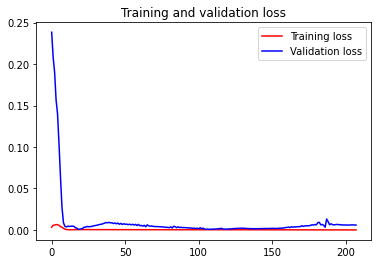

<Figure size 432x288 with 0 Axes>

In [77]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [78]:
from keras.models import load_model
model_from_saved_checkpoint60 = load_model('/content/my_best_model60.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [79]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint60.predict(X_train)
test_predict=model_from_saved_checkpoint60.predict(X_test)
train_predict.shape, test_predict.shape

((1566, 1), (1025, 1))

In [80]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [81]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


test_predict 
 [[30157.678]
 [31201.297]
 [30736.451]
 [32989.344]
 [31734.49 ]
 [31138.016]
 [31116.809]
 [29732.883]
 [29336.617]]
original_ytest 
 [[29832.914063]
 [29906.662109]
 [31370.671875]
 [31155.478516]
 [30214.355469]
 [30111.998047]
 [29083.804688]
 [28360.810547]
 [26762.648438]]


## `RESULT W=60

In [82]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1003.4429377120152
Train data MSE:  1006897.7292441194
Train data MAE:  873.7518687728437
-------------------------------------------------------------------------------------
Test data RMSE:  1549.756065852014
Test data MSE:  2401743.863645112
Test data MAE:  990.7538023766465


In [83]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9726381443554595
Test data explained variance regression score: 0.9933281243914382


In [84]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.927584699521107
Test data R2 score: 0.9930925411760877


In [85]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.6344789971686944
Test data MGD:  0.0021256520467143876
----------------------------------------------------------------------
Train data MPD:  695.0468942254246
Test data MPD:  61.1543344514748


## Custom Score 

In [86]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [87]:
Y_score(original_ytrain, train_predict)

Y error nigative : [-1.88408028]
Y error positive : [0.03324689]
Y total_error : [-1.85083339]


In [88]:
Y_score(original_ytest, test_predict)

Y error nigative : [-0.03789735]
Y error positive : [0.02812808]
Y total_error : [-0.00976927]


In [89]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [90]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [91]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [92]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [93]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [94]:
time_step=60
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint60.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint60.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.58672797 0.60318862 0.61322791 0.61132297 0.59875387 0.58707473
 0.58331164 0.58305288 0.59772915 0.56299266 0.57966697 0.58757196
 0.57029898 0.55701858 0.56821064 0.56910448 0.55754653 0.58645223
 0.54010575 0.53217833 0.52418042 0.50277198 0.44694198 0.4577146
 0.42675169 0.42840474 0.43189718 0.44403812 0.46190235 0.44050121
 0.44885483 0.42354516 0.4471999  0.43067497 0.43411006 0.44733922
 0.42916389 0.43742455 0.43604117 0.43166155 0.4221696  0.42494939
 0.43431381 0.4681538  0.469132   0.4395539  0.4494726  0.43814878
 0.44005597 0.44115034 0.46287519 0.45968187 0.44571629 0.44419738
 0.42893973 0.41821102 0.39449545 0.33105368 0.32688985 0.34906963]
1 day output [[0.3668758]]
2 day input [0.60318862 0.61322791 0.61132297 0.59875387 0.58707473 0.58331164
 0.58305288 0.59772915 0.56299266 0.57966697 0.58757196 0.57029898
 0.55701858 0.56821064 0.56910448 0.55754653 0.58645223 0.54010575
 0.53217833 0.52418042 0.50277198 0.44694198 0.4577146  0.42675169
 0.42840474

## Plotting last 60 days of dataset and next predicted 15 days

In [95]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
[61 62 63 64 65]


In [96]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

last_original_days_value
[40424.484375, 39716.953125, 40826.214844, 41502.75, 41374.378906, 40527.363281, 39740.320313, 39486.730469, 39469.292969, 40458.308594, 38117.460938, 39241.121094, 39773.828125, 38609.824219, 37714.875, 38469.09375, 38529.328125, 37750.453125, 39698.371094, 36575.140625, 36040.921875, 35501.953125, 34059.265625, 30296.953125, 31022.90625, 28936.355469, 29047.751953, 29283.103516, 30101.265625, 31305.113281, 29862.917969, 30425.857422, 28720.271484, 30314.333984, 29200.740234, 29432.226563, 30323.722656, 29098.910156, 29655.585938, 29562.361328, 29267.224609, 28627.574219, 28814.900391, 29445.957031, 31726.390625, 31792.310547, 29799.080077999995, 30467.488281, 29704.390625, 29832.914063, 29906.662109, 31370.671875, 31155.478516, 30214.355469, 30111.998047, 29083.804688, 28360.810547, 26762.648438, 22487.388672, 22206.792969]
next_predicted_days_value
[23701.46001604201, 24901.395271527093, 26244.828464903683, 27610.35742058846, 28988.026794665624]


In [97]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 30 days close price','Predicted next 15 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
